<a href="https://colab.research.google.com/github/StevenTaruc/LeagueOfLegendsAnalysis/blob/master/Final_Project_Steven_Taruc_and_Josiah_Lashley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# League of Legends Match Analysis

*   Exploratory Data Analysis and Summary statistics
*   Machine Learning and predicting win percentage
*   Timeline and Map Location and Analysis



In [0]:
import requests 
import json
import time
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Retrieving match statistics from a player

In [0]:
#get response for account_id from summoner id 
key = 'RGAPI-2b9f81cd-c2de-4bea-ae30-c1a3f2fb3e72'
summoner_name = 'licorice'

account_resp = requests.get('https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/%s?api_key=%s' % (summoner_name, key))
account_id = account_resp.json()['accountId']

#get response of matchlists from season 13
resp = requests.get("https://na1.api.riotgames.com/lol/match/v4/matchlists/by-account/%s?&api_key=%s" % (account_id,key))

df_games = json_normalize(resp.json()['matches'])
df_games.head()

,platformId,gameId,champion,queue,season,timestamp,role,lane
0,NA1,3328664670,429,420,13,1584501608128,SOLO,TOP
1,NA1,3328526992,104,420,13,1584498834816,DUO,MID
2,NA1,3327643642,104,420,13,1584420800770,SOLO,TOP
3,NA1,3327572194,429,420,13,1584417162854,SOLO,TOP
4,NA1,3327515909,429,420,13,1584415337824,SOLO,TOP


## What role do you play the most?

(SOLO           57
 DUO_SUPPORT    20
 DUO            18
 DUO_CARRY       3
 NONE            2
 Name: role, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22d68afdd8>)

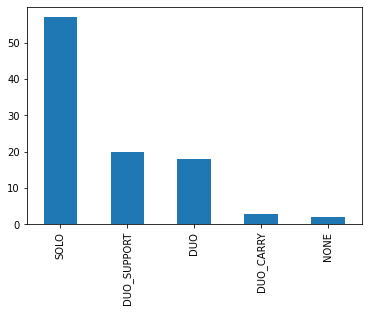

In [0]:
role_counts = df_games['role'].value_counts()
most_used_role = role_counts[[0]].index[0]
role_counts, role_counts.plot.bar()

## What lane do you play the most?

(TOP       64
 NONE      24
 MID       10
 JUNGLE     2
 Name: lane, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22d6872c18>)

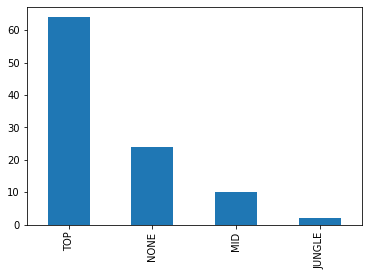

In [0]:
lane_counts = df_games['lane'].value_counts()
most_used_lane = lane_counts[[0]].index[0]
lane_counts, lane_counts.plot.bar()

## What champion do you play the most? 

In [0]:
# Retrieve champion data from ddragon 
champions_resp = requests.get('http://ddragon.leagueoflegends.com/cdn/9.3.1/data/en_US/champion.json')

In [0]:
champs = pd.DataFrame(champions_resp.json()['data'].keys(),
                      columns=['champion_name'])
champs.set_index('champion_name',inplace=True)
for champ in champs.index:
  champ_id = int(champions_resp.json()['data'][champ]['key'])
  champs.loc[champ,'champion'] = champ_id
champs.reset_index(inplace=True)

df_games = df_games.merge(champs,on = 'champion',how='left')

(Kalista    16
 Camille    10
 Irelia      8
 Aatrox      7
 Lucian      6
 Name: champion_name, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22dae91ac8>)

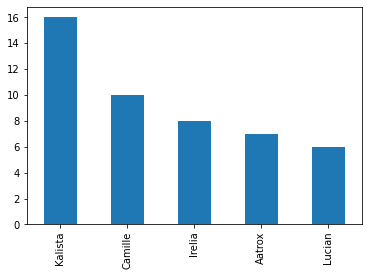

In [0]:
champ_counts = df_games['champion_name'].value_counts()
most_used_champ = champ_counts[[0]].index[0]
champ_counts[:5], champ_counts[:5].plot.bar()

In [0]:
df_game_stats = pd.DataFrame()

for match in df_games['gameId']:
  match_response = requests.get('https://na1.api.riotgames.com/lol/match/v4/matches/%s?api_key=%s' % (match,key))
  participants = json_normalize(match_response.json()['participantIdentities'])
  participant_id = participants[participants['player.accountId'] == account_id]['participantId'].values[0]
  p_stats = json_normalize(match_response.json()['participants'])
  row = p_stats[p_stats['participantId'] == participant_id]
  df_game_stats = pd.concat([df_game_stats,row],sort=False)
  time.sleep(1.5)
df_game_stats.reset_index(inplace=True)

In [0]:
champs2 = champs.rename(columns={"champion": "championId"})
df_game_stats = df_game_stats.merge(champs2,on = 'championId',how='left')

In [0]:
#taking out unused variables and cleaning column names
df_gs = df_game_stats.iloc[:,7:127]

df_gs = pd.concat([df_gs,df_game_stats['champion_name']], axis = 1)

df_gs['team_color'] = df_game_stats['teamId'].map({
    100 : 'blue',
    200 : 'red'
})

df_gs.columns = df_gs.columns.str.replace(r'stats.', '')
df_gs.columns = df_gs.columns.str.replace(r'timeline.', '')

df_gs.head()

,win,item0,item1,item2,item3,item4,item5,item6,kills,deaths,assists,largestKillingSpree,largestMultiKill,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,quadraKills,pentaKills,unrealKills,totalDamageDealt,magicDamageDealt,physicalDamageDealt,trueDamageDealt,largestCriticalStrike,totalDamageDealtToChampions,magicDamageDealtToChampions,physicalDamageDealtToChampions,trueDamageDealtToChampions,totalHeal,totalUnitsHealed,damageSelfMitigated,damageDealtToObjectives,damageDealtToTurrets,visionScore,timeCCingOthers,totalDamageTaken,magicalDamageTaken,physicalDamageTaken,trueDamageTaken,...,perk2,perk2Var1,perk2Var2,perk2Var3,perk3,perk3Var1,perk3Var2,perk3Var3,perk4,perk4Var1,perk4Var2,perk4Var3,perk5,perk5Var1,perk5Var2,perk5Var3,perkPrimaryStyle,perkSubStyle,statPerk0,statPerk1,statPerk2,participantId,creepsPerMinDeltas.10-20,creepsPerMinDeltas.0-10,xpPerMinDeltas.10-20,xpPerMinDeltas.0-10,goldPerMinDeltas.10-20,goldPerMinDeltas.0-10,csDiffPerMinDeltas.10-20,csDiffPerMinDeltas.0-10,xpDiffPerMinDeltas.10-20,xpDiffPerMinDeltas.0-10,damageTakenPerMinDeltas.10-20,damageTakenPerMinDeltas.0-10,damageTakenDiffPerMinDeltas.10-20,damageTakenDiffPerMinDeltas.0-10,role,lane,champion_name,team_color
0,False,3153,3085,3006,1053,1055,0,3340,4,7,3,2,1,2,394,0,0,0,0,0,94246,238,84397,9610,303,11098,238,10859,0,538,1,8086,2519,2519,19,7,14803,5623,6657,2522,...,8120,1,4,3,8135,381,2,0,9101,1241,2066,0,9104,13,20,0,8100,8000,5005,5008,5002,10,6.9,7.6,404.4,436.8,452.4,331.5,2.6,4.3,-40.3,100.0,812.3,355.3,164.2,-361.4,SOLO,TOP,Kalista,red
1,False,2055,3046,3065,3047,3072,3812,3340,7,9,10,3,2,2,504,1,0,0,0,0,257974,2667,255167,140,572,33710,1587,31982,140,3326,1,54683,17305,4475,40,26,26405,10044,11863,4496,...,9103,27,50,0,8299,868,0,0,8233,25,40,0,8236,28,0,0,8000,8200,5005,5008,5002,9,8.9,7.7,608.6,461.8,425.9,316.4,NaN,NaN,NaN,NaN,507.6,381.0,NaN,NaN,DUO,MIDDLE,Graves,red
2,False,2055,3812,3047,3123,1055,1038,3340,2,12,3,0,1,0,300,0,0,0,0,0,114013,767,100972,12274,0,18796,407,17930,459,1820,1,28079,2630,2630,10,15,23839,3138,18023,2677,...,9103,0,0,0,8299,901,0,0,8446,953,0,0,8429,57,17,11,8000,8400,5005,5008,5002,6,7.3,7.5,448.9,458.0,462.9,289.4,0.7,0.2,-171.8,-60.3,1225.3,591.3,1.1,-17.0,SOLO,TOP,Graves,red
3,True,3153,3033,1055,3085,3006,1083,3340,2,8,8,0,1,0,279,0,0,0,0,0,161122,991,159835,295,468,16008,638,15229,139,5443,1,15750,10931,4990,35,13,22834,6678,15600,556,...,8120,4,18,9,8135,1534,5,0,9101,6359,5094,0,9104,23,10,0,8100,8000,5005,5008,5002,9,8.7,5.4,502.9,356.5,424.8,220.6,0.1,-0.5,-147.5,-88.1,785.6,465.4,185.0,55.9,SOLO,TOP,Kalista,red
4,False,3153,1053,3006,1055,1038,3085,3340,3,8,1,2,1,1,431,0,0,0,0,0,129892,654,128277,960,364,15788,654,14581,552,2346,1,12314,6401,5355,26,12,19128,8292,9737,1098,...,8120,2,9,6,8135,846,3,0,9101,1959,2928,0,9104,20,40,0,8100,8000,5005,5008,5003,3,8.7,8.0,494.3,436.8,525.8,306.0,NaN,NaN,NaN,NaN,1035.6,404.8,NaN,NaN,SOLO,TOP,Kalista,blue


# Machine Learning Analysis

## Simple Linear Regression on damage taken vs. damage on other champions

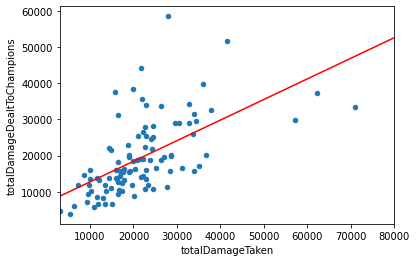

In [0]:
X_train = df_gs[['totalDamageTaken']]  
y_train = df_gs['totalDamageDealtToChampions']

model = LinearRegression()
model.fit(X=X_train, y=y_train)

X_new = pd.DataFrame()
X_new["totalDamageTaken"] = np.linspace(3000,80000,num = 50)

y_new_ = pd.Series(
    model.predict(X_new),
    index=X_new["totalDamageTaken"]
)

df_gs.plot.scatter(x="totalDamageTaken", y="totalDamageDealtToChampions")
y_new_.plot.line(c = 'red')

In [0]:
model.score(X=X_train,y=y_train)

0.3530405561675627

In [0]:
scores = -cross_val_score(model, 
                         X=X_train,
                         y=y_train,
                         scoring="neg_mean_squared_error",
                         cv=10)
np.sqrt(scores.mean())

8668.7789915207

## Predicting Win Probability using Pre-match Attributes

In [0]:
X_train = df_gs[['champion_name',
                 'role',
                 'lane']].fillna('none')       
y_train = df_gs['win'].fillna('none')

pipeline = make_pipeline(make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['champion_name','role','lane'])),
    StandardScaler(with_mean=False),
    KNeighborsClassifier(n_neighbors=10)
)

pipeline.fit(X = X_train, y = y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['champion_name', 'role',
                                                   'lane'])],
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, w

In [0]:
test1 = pd.DataFrame({
    'champion_name':[most_used_champ],
    'role':[most_used_role],
    'lane':[most_used_lane]
})
test1

,champion_name,role,lane
0,Kalista,SOLO,TOP


In [0]:
pipeline.predict_proba(test1)

array([[0.6, 0.4]])

We are able to setup a k-nearest neighbors classifier that predicts game outcome from pre-match attributes. Using our most used champion, role, and lane from our collected data of 100 matches, we predict to have a 60% chance of winning and 40% chance of losing a match. 

In [0]:
is_win = (y_train == True)

accuracy_scores = cross_val_score(pipeline, X_train, y_train, 
                            cv=10, scoring="accuracy")

precision_scores = cross_val_score(pipeline, X_train, is_win, 
                cv=10, scoring="precision")

recall_scores = cross_val_score(pipeline, X_train, is_win, 
                cv=10, scoring="recall")

accuracy_scores.mean(), precision_scores.mean(), recall_scores.mean()

(0.5299999999999999, 0.5916666666666666, 0.36333333333333334)

However, our model is not a good predictor of game outcome. Calculating our model accuracy, precision, and recall, we see that the pre-game decisions are not the best for determining whether you'll win or lose a match. 

# Analysis on Match Timeline Data

In [0]:
def get_player_data(key,summoner_name,game_type):
  #
  # creating then getting summoners encrypted account Id
  #
  frst_link="https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/%s?api_key=%s"%(summoner_name,key)
  response = requests.get(frst_link)
  encrypt_id = response.json()["accountId"]
  time.sleep(1.5)
  #
  # creating then getting the past 100 matches from the summoner
  #
  matches_link = "https://na1.api.riotgames.com/lol/match/v4/matchlists/by-account/%s?api_key=%s" % (encrypt_id,key)
  match_resp = requests.get(matches_link)
  #
  # quickly retrieving the queue codes
  #
  que_resp = requests.get("http://static.developer.riotgames.com/docs/lol/queues.json")
  df_queId = json_normalize(que_resp.json())
  df_matchlist = json_normalize(match_resp.json()["matches"])
  #
  # merging queue codes and the matches
  #
  df_matches = df_matchlist.merge(df_queId, 
                   left_on = "queue",
                   right_on = "queueId",
                   how = "left").drop(columns = ["queue"])
  # 
  # Filtering by the selected match type
  #
  df_game_types = df_matches[df_matches["description"] == game_type]
  df_summoner_final = pd.DataFrame()
  for g_id in df_game_types["gameId"].astype(str):
    df_game = get_game_data(g_id,key,summoner_name)
    df_summoner_final = pd.concat([df_game,df_summoner_final], sort=False)
  # return it boy
  return df_summoner_final


In [0]:
def get_game_data(game_id,key,name):
  #
  # Creating then getting the infromation for kills and objects dataframes
  #
  time.sleep(1.5)
  game_link = "https://na1.api.riotgames.com/lol/match/v4/matches/%s?api_key=%s" % (game_id, key)
  game_resp = requests.get(game_link)
  no_turrets = json_normalize(game_resp.json()["teams"])["towerKills"].sum()
  if no_turrets == 0:
    return pd.DataFrame()
  #
  # getting participantId, teamId, team_win
  #
  df_getting_Id = json_normalize(game_resp.json()["participantIdentities"])
  participant_id = str(df_getting_Id[df_getting_Id["player.summonerName"]==name]["participantId"].iloc[0])
  team_id = json_normalize(game_resp.json()["participants"][int(participant_id) - 1])["teamId"][0]
  team_win = json_normalize(game_resp.json()["participants"][int(participant_id) - 1])["stats.win"][0]
  #
  # creating the timeline of events dataset
  #
  time.sleep(1.5)
  time_link = "https://na1.api.riotgames.com/lol/match/v4/timelines/by-match/%s?api_key=%s" % (game_id, key)
  time_resp = requests.get(time_link)
  df_timeline = json_normalize(time_resp.json()["frames"],"events")
  #
  # getting kills and objectives data and merging together
  #
  df_ks = get_kill_level(df_timeline,participant_id)
  if len(df_ks) == 0:
    remake = True
  else:
    remake = False
  df_game_final = get_w_objectives(df_timeline,df_ks,team_id,team_win,remake)
  df_game_final["game_id"] = game_id
  return df_game_final


In [0]:
def get_kill_level(df_timeline,player_id):
  #
  # getting kills and leveling up events for the summoner specifically
  #
  df_events = df_timeline[df_timeline["type"].isin(["CHAMPION_KILL",
                                                  "SKILL_LEVEL_UP"])][[ "type",
                                                                        "participantId",
                                                                        "timestamp",
                                                                        "killerId",
                                                                        "victimId",
                                                                        "assistingParticipantIds",
                                                                        "position.x",
                                                                        "position.y"]].astype(str).reset_index().drop(columns=["index"])
  did_assist = pd.Series([player_id in r[0] for r in zip(df_events["assistingParticipantIds"])])
  df_events["did_assist"] = did_assist
  df = df_events[(df_events["killerId"] == str(float(player_id))) | 
               (df_events["victimId"] == str(float(player_id))) |
               (df_events["participantId"] == str(float(player_id))) |
               (df_events["did_assist"])]
  df["kill"] = (df["killerId"] == str(float(player_id)))
  df["death"] = (df["victimId"] == str(float(player_id)))
  df["level_up"] = (df["type"] == "SKILL_LEVEL_UP")
  df["kill"] = df["kill"].map({
      True : 1,
      False: 0 })
  df["death"] = df["death"].map({
      True : 1,
      False: 0 })
  df["assist"] = df["did_assist"].map({
      True : 1,
      False: 0 })
  df["level_up"] = df["level_up"].map({
      True : 1,
      False: 0 })
  df["kill_assisting"] = df["assistingParticipantIds"].str.replace(
                                "nan","[]"
                            ).str.replace(
                                ", ", ""
                            ).str.replace(
                                "0", ""
                            ).str.len() - 1
  df_kills = df.reset_index().drop(columns=["participantId","killerId","victimId",
                                          "assistingParticipantIds",
                                          "did_assist", "index"])
  return df_kills

In [0]:
def get_w_objectives(df_timeline, df_kills, team_id, team_win, remake):
  if remake:
    return pd.DataFrame()
  #
  # getting objectives then merging it with the kills dataframe
  #
  df_obj = df_timeline[df_timeline["type"].isin(["BUILDING_KILL",
                                               "ELITE_MONSTER_KILL"])][["type",
                                                                        "timestamp",
                                                                        "killerId",
                                                                        "assistingParticipantIds",
                                                                        "teamId",
                                                                        "position.x",
                                                                        "position.y",
                                                                        "buildingType",
                                                                        "laneType",
                                                                        "towerType",]].astype(str).reset_index().drop(columns=["index"])
  if float(team_id) == 200.0:
    teammates = ["1.0","2.0","3.0","4.0","5.0"]
  else:
    teammates = ["6.0","7.0","8.0","9.0","10.0"]
  df_objectives = df_obj[(df_obj["teamId"] == team_id) | 
               (df_obj["killerId"].isin(teammates))]
  df_objectives["tower_assisting"] = df_obj["assistingParticipantIds"].str.replace(
                                "nan","[]"
                            ).str.replace(
                                ", ", ""
                            ).str.replace(
                                "0", ""
                            ).str.len() - 1
  df_objectives["tower_kill"] = df_objectives["type"] == "BUILDING_KILL"
  df_objectives["tower_kill"] = df_objectives["tower_kill"].map({
      True: 1,
      False: 0
  })
  df_final = df_objectives.merge(df_kills, how = "outer")
  df_final["minute"] = (df_final["timestamp"].astype(float) / 60000)
  df_final = df_final.sort_values(by=["minute"]
              ).reset_index().drop(columns = ["index"]
              ).drop(columns = ["killerId","teamId","assistingParticipantIds"])
  df_final["position.x"] = df_final["position.x"].astype(float)
  df_final["position.y"] = df_final["position.y"].astype(float)
  df_final["timestamp"] = df_final["timestamp"].astype(float)
  df_final["towerType"] = df_final["towerType"].fillna("nan")
  df_final["buildingType"] = df_final["buildingType"].fillna("nan")
  df_final["laneType"] = df_final["laneType"].fillna("nan")
  df_final["tower_kill"] = df_final["tower_kill"].fillna(0)
  df_final["tower_assisting"] = df_final["tower_assisting"].fillna(0)
  df_final["kill"] = df_final["kill"].fillna(0)
  df_final["death"] = df_final["death"].fillna(0)
  df_final["assist"] = df_final["assist"].fillna(0)
  df_final["kill_assisting"] = df_final["kill_assisting"].fillna(0)
  df_final["level_up"] = df_final["level_up"].fillna(0)
  # Adding up for the times
  df_final["kills"] = df_final["kill"].cumsum()
  df_final["deaths"] = df_final["death"].cumsum()
  df_final["assists"] = df_final["assist"].cumsum()
  df_final["level"] = df_final["level_up"].cumsum() + 1
  df_final["kill_participation"] = df_final["kill_assisting"].cumsum()
  df_final["tower_kills"] = df_final["tower_kill"].cumsum()
  df_final["team_participation"] = df_final["tower_assisting"].cumsum()
  if team_win:
    df_final["win"] = 1
  else:
    df_final["win"] = 0 
  return df_final

# Getting in the Data of Me, Friend, and Gbay

**My data will be on a specific Game mode called URF**

**Friend's Nick data will be on ranked games**

**Gbay is a famous league of legends youtuber and it will also be on ranked games**

In [0]:
# reading in my URF data
ky = "RGAPI-3caeba99-f865-41db-aa31-eef435377e33"
name = "DODEisBOSS"
game = "URF games"
df_dode_urf = get_player_data(ky,name,game)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

KeyError: ignored

In [0]:
# reading in Nick's ranked data
ky = "RGAPI-3caeba99-f865-41db-aa31-eef435377e33"
name = "big arms"
game = "5v5 Ranked Solo games"
df_nick_ranked = get_player_data(ky,name,game)

In [0]:
# reading in Gbay's ranked data
ky = "RGAPI-3caeba99-f865-41db-aa31-eef435377e33"
name = "Gbay99"
game = "5v5 Ranked Solo games"
df_gbay_ranked = get_player_data(ky,name,game)

In [0]:
img = plt.imread("LeagueMap.png")

In [0]:
df_plot = df_gbay_ranked[df_gbay_ranked["type"] == "CHAMPION_KILL"]
df_plot["map.y"] = (15000 - df_plot["position.y"]) / 29.3
df_plot["map.x"] = df_plot["position.x"] / 29.3

In [0]:
df_kills = df_plot[df_plot["kill"] == 1]
df_k00 = df_kills[df_kills["minute"] < 17]
df_k17 = df_kills[(df_kills["minute"] >= 17)]

In [0]:
plt.rcParams["figure.figsize"]=11,11

In [0]:
imgplot = plt.imshow(img)
plt.scatter(x=df_k00["map.x"], y=df_k00["map.y"], c="r", s=100, alpha=.5)
plt.scatter(x=df_k15["map.x"], y=df_k15["map.y"], c="b", s=100, alpha=.5)

In [0]:
df_dode = df_dode_urf[df_dode_urf["minute"].notna()]
df_dode_10 = df_dode[df_dode["minute"]>10]

In [0]:
df_nick_ranked = df_nick[df_nick["minute"].notna()]
df_nick_10 = df_nick_ranked[df_nick_ranked["minute"]>10]

In [0]:
df_gbay = df_gbay_ranked[df_gbay_ranked["minute"].notna()]
df_gbay_10 = df_gbay[df_gbay["minute"]>10]

In [0]:
features = ["tower_assisting", "tower_kill", "kill", "death","level_up","assist",
            "minute","kills","deaths","level","kill_participation","tower_kills",
            "team_participation"]

model1 = make_pipeline(
  StandardScaler(with_mean=False),
  #KNeighborsClassifier(n_neighbors=1, metric="manhattan")
  #RandomForestRegressor(n_estimators=100,oob_score=True)
  MLPClassifier(hidden_layer_sizes=(10,), max_iter=10000)
  )

model1.fit(X=df_gbay_10[features],y=df_gbay_10["win"])

cv_errs = cross_val_score(model1,X=df_gbay_10[features],
                                  y=df_gbay_10["win"],
                                  scoring="f1_macro", 
                                  #scoring="neg_mean_squared_error",
                                  cv=30)
cv_errs.mean()

In [0]:
features = ["tower_assisting", "tower_kill", "kill", "death","level_up","assist",
            "minute","kills","deaths","level","kill_participation","tower_kills",
            "team_participation"]

model2 = make_pipeline(
  StandardScaler(with_mean=False),
  #KNeighborsClassifier(n_neighbors=1, metric="manhattan")
  #RandomForestRegressor(n_estimators=100,oob_score=True)
  MLPClassifier(hidden_layer_sizes=(10,), max_iter=10000)
  )

model2.fit(X=df_nick_10[features],y=df_nick_10["win"])

cv_errs = cross_val_score(model2,X=df_nick_10[features],
                                  y=df_nick_10["win"],
                                  scoring="f1_macro", 
                                  #scoring="neg_mean_squared_error",
                                  cv=30)
cv_errs.mean()

In [0]:
features = ["tower_assisting", "tower_kill", "kill", "death","level_up","assist",
            "minute","kills","deaths","level","kill_participation","tower_kills",
            "team_participation"]

model3 = make_pipeline(
  StandardScaler(with_mean=False),
  #KNeighborsClassifier(n_neighbors=1, metric="manhattan")
  #RandomForestRegressor(n_estimators=100,oob_score=True)
  MLPClassifier(hidden_layer_sizes=(10,), max_iter=10000)
  )

model3.fit(X=df_dode_10[features],y=df_dode_10["win"])

cv_errs = cross_val_score(model3,X=df_dode_10[features],
                                  y=df_dode_10["win"],
                                  scoring="f1_macro", 
                                  #scoring="neg_mean_squared_error",
                                  cv=30)
cv_errs.mean()